In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### Questão 1)

In [2]:
rlog_bayesiana = np.genfromtxt("/content/drive/MyDrive/topicos avançados em ML/logistic_regression_data.csv", delimiter = ',')

In [3]:
rlog_bayesiana.shape

(100, 3)

In [4]:
def media_e_desvio_padrao(dataset, manter_dimensoes=True):
  media = np.mean(dataset, axis=0, keepdims = manter_dimensoes)
  desvio_padrao = np.std(dataset, axis=0, keepdims = manter_dimensoes)

  return media, desvio_padrao

In [5]:
def normalizar(dataset, adicionar_uns = True):
  x_data = dataset[:, :-1]
  y_data = dataset[:, -1]

  x_media, x_desvio_padrao = media_e_desvio_padrao(x_data, manter_dimensoes = False)

  # normalizando
  x_data = ((x_data - x_media)/x_desvio_padrao)

  if adicionar_uns:
    x_data = np.c_[np.ones(x_data.shape[0]), x_data]

  return x_data, x_media, x_desvio_padrao, y_data

In [6]:
def normalizar_ponto(ponto, media, desvio_padrao):
  normal = ((ponto - media)/desvio_padrao)

  return normal

In [7]:
def desnormalizar_ponto(ponto, media, desvio_padrao):
  desnormal = ((ponto*desvio_padrao) + media)

  return desnormal

In [8]:
def sigmoid(valor):
  sig = 1/(1 + np.exp(-valor))

  return sig

In [9]:
def irls(x_data, y_data, max_iteracao):
  m_inicial = np.zeros(x_data.shape[1])
  S_inicial = np.eye(x_data.shape[1])
  w = np.zeros(x_data.shape[1])

  for i in range(max_iteracao):
    p =  x_data @ w
    M = sigmoid(p) * (1-sigmoid(p)) # matriz de pesos
    M = M * np.eye(M.shape[0])
    A = (x_data.T @ M @ x_data) + np.linalg.inv(S_inicial)
    w = w + np.linalg.inv(A)@(x_data.T@(y_data - sigmoid(x_data @ w)) - (np.linalg.inv(S_inicial)@(w - m_inicial)))

  return w, M

In [10]:
def regressao_logistica_bayesiana(x_data, y_data, max_iteracao):
  w, M = irls(x_data, y_data, max_iteracao)
  H = x_data.T @ M @ x_data + np.linalg.inv(np.eye(x_data.shape[1]))

  return w, np.linalg.inv(H)

In [11]:
x_data, x_media, x_desvio_padrao, y_data = normalizar(rlog_bayesiana)

In [12]:
m, S = regressao_logistica_bayesiana(x_data, y_data, 15)

In [13]:
x1_min, x1_max = np.min(rlog_bayesiana[:, 0]) - 0.5, np.max(rlog_bayesiana[:, 0]) + 0.5
x2_min, x2_max = np.min(rlog_bayesiana[:, 1]) - 0.5, np.max(rlog_bayesiana[:, 1]) + 0.5

In [14]:
passo = 0.01
x1, x2 = np.mgrid[slice(x1_min, x1_max, passo), slice(x2_min, x2_max, passo)]

In [16]:
x_plot = np.dstack((x1, x2))

x_plot_normalizado = (x_plot - x_media) / x_desvio_padrao
x_plot_normalizado = np.dstack((np.ones(x1.shape), x_plot_normalizado))
valores = np.apply_along_axis(lambda x: np.sqrt(1 + (np.pi * (x.T @ S @ x)/ 8)) * (m.T @ x), axis=2, arr=x_plot_normalizado)

In [17]:
x, y = rlog_bayesiana[:, [0, 1]], rlog_bayesiana[:, -1]

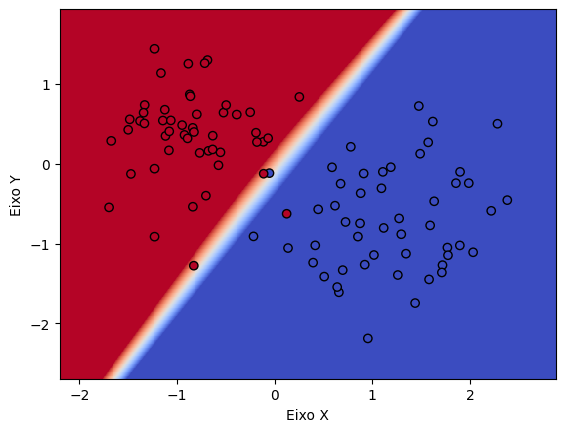

In [18]:
back = plt.pcolormesh(x1, x2, valores, vmin=0, vmax=1, cmap='coolwarm')
scatter = plt.scatter(x=x[:, 0], y=x[:, 1], c=y, cmap='coolwarm', marker='o', edgecolor='k')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.show()

#### Questão 2)

In [19]:
nv_bayesiana = np.genfromtxt("/content/drive/MyDrive/topicos avançados em ML/votesDataset.csv", dtype = str, delimiter = ',', skip_header = 1)

In [20]:
nv_bayesiana.shape

(435, 17)

In [21]:
y_data_nv = (nv_bayesiana[:, 0] == 'democrat').astype('int')
x_data_nv = nv_bayesiana[:, 1:].astype('int')

In [22]:
m1 = np.ones(2)
m2 = np.zeros(2)
beta = np.ones((2, x_data_nv.shape[1], 2))
theta = np.zeros((2, x_data_nv.shape[1]))

In [23]:
counts = np.bincount(y_data_nv)
m2 = (m1 + counts) / (y_data_nv.shape[0] + np.sum(m1))

In [24]:
c0 = x_data_nv[y_data_nv == 0]
c1 = x_data_nv[y_data_nv == 1]

In [25]:
for i in range(x_data_nv.shape[1]):
  theta[0, i] = (np.sum(c0[:, i] == 1) + beta[0, i, 1])/(c0.shape[0] + np.sum(beta[0, i]))
  theta[1, i] = (np.sum(c1[:, i] == 1) + beta[1, i, 1])/(c1.shape[0] + np.sum(beta[1, i]))

In [26]:
p1 = m2[1] * np.prod(theta[1]**x_data_nv * (1 - theta[1])**(1 - x_data_nv), axis=1)
p0 = m2[0] * np.prod(theta[0]**x_data_nv * (1 - theta[0])**(1 - x_data_nv), axis=1)

In [27]:
pn = np.column_stack(((p1 > p0).astype('int'), y_data_nv))

In [28]:
true_p = np.sum(pn[pn[:, 1] == 1, 0] == 1)
true_n = np.sum(pn[pn[:, 1] == 0, 0] == 0)
false_p = np.sum(pn[pn[:, 1] == 0, 0] == 1)
false_n = np.sum(pn[pn[:, 1] == 1, 0] == 0)

print("Democrata(1) e Republicano(0):")
print("True Positive:", true_p)
print("True Negative:", true_n)
print("False Positive:", false_p)
print("False Negative:", false_n)

Democrata(1) e Republicano(0):
True Positive: 239
True Negative: 148
False Positive: 20
False Negative: 28


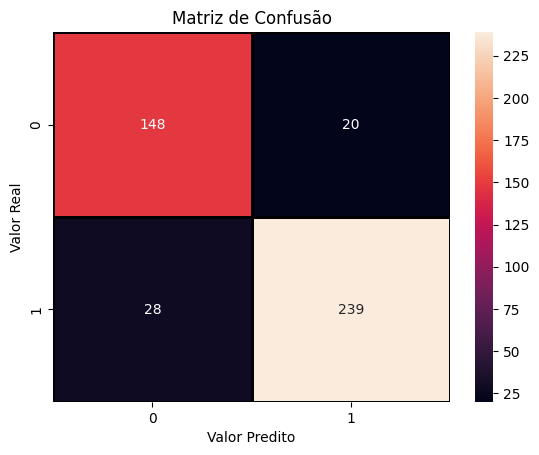

In [29]:
mc = np.array([[true_n, false_p], [false_n, true_p]])

plot = sns.heatmap(mc, annot=True, fmt='d', cbar=True, linewidths=1, linecolor='black')
plot.set_xlabel("Valor Predito")
plot.set_ylabel("Valor Real")
plt.title("Matriz de Confusão")
plt.show()